# 캔들스틱 패턴 머신러닝 학습

__아래 그림의 캔들스틱 6가지 패턴을 분류해서 학습 시켜보자.__

![img1](https://drive.google.com/uc?export=view&id=18hCajCvPNIxIrrCPfkdYcT9Z9rNRBC-n)

## 1) 데이터 수집 및 전처리

수집된 데이터를 가지고 캔들스틱 Label을 붙이는 작업을 실시하고, 2개의 DataFrame을 준비한다.

1. 시가, 고가, 저가, 종가, Label 명시된 DataFrame
2. 머리, 몸통, 꼬리, Label 명시된 DataFrame
3. Label은 아래와 같이 index 처리를 한다.
- 0 : Long Upper Shadow
- 1 : Long Lower Shadow
- 2 : Upper Marubozu
- 3 : Lower Marubozu
- 4 : Long Doji
- 5 : Df Doji
- 6 : Gs Doji



### 1.1 Loading csv file

In [ ]:
# [solved] error : Invalid RGBA argument: masked
# ref: https://zereight.tistory.com/246 [Zereight's Blog]

!pip install --upgrade --user matplotlib

## And restart runtime.

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
file_name = 'https://drive.google.com/uc?export=download&id=1EZsoGjhO38krC4xzeWAUiDU3AHetTzAm'
raw_df = pd.read_csv(file_name, header=None)
raw_df.columns = ["Day", "Time", "Open", "High", "Low", "Close", "Volume"]
raw_df

,Day,Time,Open,High,Low,Close,Volume
0,1993.05.12,00:00,1.53700,1.54450,1.52900,1.53380,2781
1,1993.05.13,00:00,1.53280,1.53600,1.51800,1.52250,2571
2,1993.05.14,00:00,1.52280,1.54150,1.52000,1.53870,2711
3,1993.05.17,00:00,1.53650,1.54600,1.53090,1.53550,2921
4,1993.05.18,00:00,1.53500,1.53800,1.52370,1.53650,2711
...,...,...,...,...,...,...,...
1689971,2021.11.29,02:15,1.33354,1.33358,1.33312,1.33352,391
1689972,2021.11.29,02:20,1.33353,1.33376,1.33325,1.33352,416
1689973,2021.11.29,02:25,1.33352,1.33353,1.33284,1.33285,336
1689974,2021.11.29,02:30,1.33286,1.33316,1.33283,1.33306,321


### 1.2 Data preprocessing

In [ ]:
point = 100000.0
# Open, High, Low, Close, Label
basic_df = pd.DataFrame([], columns=['Open', 'High', 'Low', 'Close', 'Label'])
# Head, Body, Tail, Label
processed_df = pd.DataFrame([], columns=['Head', 'Body', 'Tail', 'Label'])




def GetBody(index):
    body = raw_df["Close"][index] - raw_df["Open"][index]
    body = round(body*point)
    return body

def GetHead(index):
    head = raw_df["High"][index] - raw_df["Close"][index] if raw_df["Close"][index] > raw_df["Open"][index] else raw_df["High"][index] - raw_df["Open"][index]
    head = round(head*point)
    return head

def GetTail(index):
    tail = raw_df["Open"][index] - raw_df["Low"][index] if raw_df["Close"][index] > raw_df["Open"][index] else raw_df["Close"][index] - raw_df["Low"][index]
    tail = round(tail*point)
    return tail

def CreateLabel():
    u_shadow_count = 0
    l_shadow_count = 0
    u_marubozu_count = 0
    l_marubozu_count = 0
    l_doji_count = 0
    d_doji_count = 0
    g_doji_count = 0

    for i in range(0, len(raw_df)):
        all_count = u_shadow_count + l_shadow_count + u_marubozu_count + l_marubozu_count + l_doji_count + d_doji_count + g_doji_count
        if all_count == 7000:
            break
        body = GetBody(i)
        head = GetHead(i)
        tail = GetTail(i)
        global basic_df
        global processed_df

        # collect doji
        if body == 0:
            if l_doji_count < 1000 and tail >= 50 and head >= 50: # long doji
                l_doji_count += 1
                basic_df.loc[i] = [raw_df["Open"][i], raw_df["High"][i], raw_df["Low"][i], raw_df["Close"][i],  4]
                processed_df.loc[i] = [head, body, tail,  4]
            if d_doji_count < 1000 and head == 0 and tail >= 50: # df doji
                d_doji_count += 1
                basic_df.loc[i] = [raw_df["Open"][i], raw_df["High"][i], raw_df["Low"][i], raw_df["Close"][i],  5]
                processed_df.loc[i] = [head, body, tail,  5]
            if g_doji_count < 1000 and tail == 0 and head >= 50: # gs doji
                g_doji_count += 1
                basic_df.loc[i] = [raw_df["Open"][i], raw_df["High"][i], raw_df["Low"][i], raw_df["Close"][i],  6]
                processed_df.loc[i] = [head, body, tail,  6]

        # collect marubozu
        if head+tail == 0:
            if u_marubozu_count < 1000 and body >= 50: # upper marubozu
                u_marubozu_count += 1
                basic_df.loc[i] = [raw_df["Open"][i], raw_df["High"][i], raw_df["Low"][i], raw_df["Close"][i],  2]
                processed_df.loc[i] = [head, body, tail,  2]
            elif l_marubozu_count < 1000 and body <= -50: # lower marubozu
                l_marubozu_count += 1
                basic_df.loc[i] = [raw_df["Open"][i], raw_df["High"][i], raw_df["Low"][i], raw_df["Close"][i],  3]
                processed_df.loc[i] = [head, body, tail,  3]

        # collect shadow
        if head <= 1 and body >= 20:
            if u_shadow_count < 1000 and body*3 <= tail*2: # long upper shadow
                u_shadow_count += 1
                basic_df.loc[i] = [raw_df["Open"][i], raw_df["High"][i], raw_df["Low"][i], raw_df["Close"][i],  0]
                processed_df.loc[i] = [head, body, tail,  0]
        if tail <= 1 and body <= -20:
            if l_shadow_count < 1000 and body*-1*3 <= head*2: # long lower shadow
                l_shadow_count += 1
                basic_df.loc[i] = [raw_df["Open"][i], raw_df["High"][i], raw_df["Low"][i], raw_df["Close"][i],  1]
                processed_df.loc[i] = [head, body, tail,  1]





CreateLabel()

In [ ]:


# data shuttle
basic_df = basic_df.sample(frac=1).reset_index(drop = True)
processed_df = processed_df.sample(frac=1).reset_index(drop = True)

print(basic_df)
print(processed_df)


        Open    High     Low   Close  Label
0     1.6215  1.6219  1.6204  1.6219    0.0
1     1.6073  1.6079  1.6067  1.6073    4.0
2     1.4569  1.4569  1.4564  1.4569    5.0
3     1.6028  1.6033  1.6028  1.6028    6.0
4     1.5762  1.5770  1.5762  1.5762    6.0
...      ...     ...     ...     ...    ...
6995  1.5597  1.5604  1.5597  1.5604    2.0
6996  1.6183  1.6187  1.6176  1.6187    0.0
6997  1.5738  1.5740  1.5731  1.5740    0.0
6998  1.6119  1.6119  1.6111  1.6119    5.0
6999  1.6302  1.6302  1.6292  1.6302    5.0

[7000 rows x 5 columns]
      Head  Body  Tail  Label
0        0    20    30      0
1        0    30    60      0
2        0    20    50      0
3       40   -20     0      1
4        0  -140     0      3
...    ...   ...   ...    ...
6995     0     0    70      5
6996     0   100     0      2
6997    60     0     0      6
6998    80   -40     0      1
6999     0   -60     0      3

[7000 rows x 4 columns]


### 1.3 Data 시각화

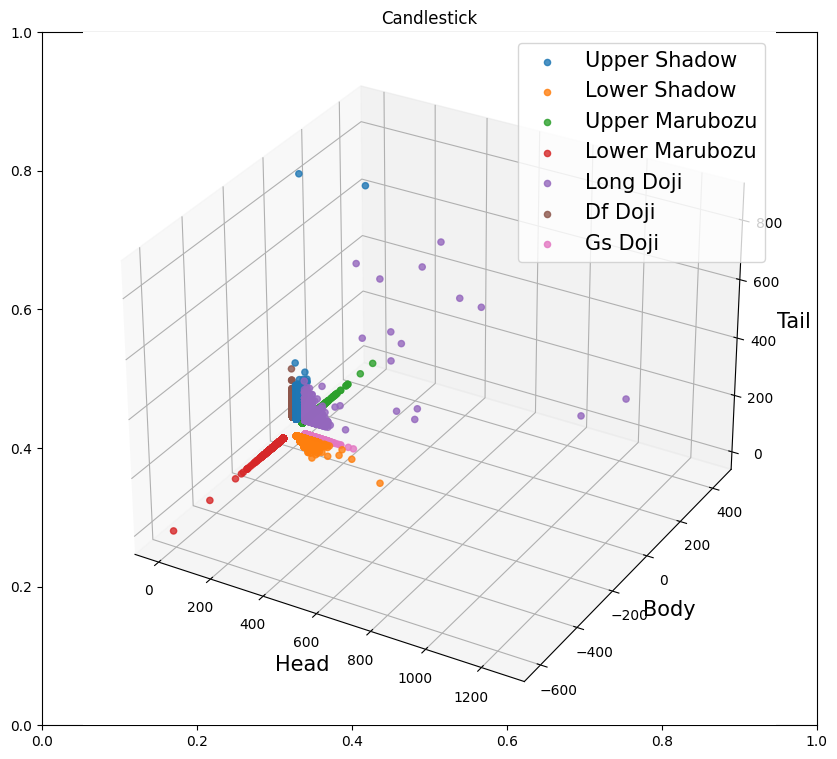

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

str_label = {0:"Upper Shadow", 1 : "Lower Shadow", 2 : "Upper Marubozu", 3 : "Lower Marubozu", 4 : "Long Doji", 5 : "Df Doji", 6 : "Gs Doji"}
my_colors = ['r', 'g']
fig = plt.figure(figsize = (10, 9))
plt.title("Candlestick")
ax = fig.add_subplot(111, projection='3d')
for i in range(0, 7):
    df_temp = processed_df[processed_df['Label'] == i]
    ax.scatter(df_temp["Head"], df_temp["Body"], df_temp["Tail"], alpha= 0.8,label=str_label[i],)

ax.set_xlabel('Head', fontsize=15)
ax.set_ylabel('Body', fontsize=15)
ax.set_zlabel('Tail', fontsize=15)
ax.legend(fontsize=15)
plt.show()


## 2) 랜덤포레스트, K-NN, 의사결정트리

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

### 2.1 Train/Test 데이터 나누기

In [6]:
# 20%를 테스트 데이터로 분류합니다
basic_train, basic_test = train_test_split(basic_df, test_size=0.2)

# DataFarame Basic
basic_x_train = basic_train[["Open", "High", "Low", "Close"]]
basic_x_test = basic_test[["Open", "High", "Low", "Close"]]
basic_y_train = basic_train[["Label"]]
basic_y_test = basic_test[["Label"]]

# DataFarame Processed
proce_train, proce_test = train_test_split(processed_df, test_size=0.2)
proce_x_train = proce_train[["Head", "Body", "Tail"]].astype(float)
proce_x_test = proce_test[["Head", "Body", "Tail"]].astype(float)
proce_y_train = proce_train[["Label"]].astype(float)
proce_y_test = proce_test[["Label"]].astype(float)




NameError: name 'basic_df' is not defined

### 2.2 매개변수 없이 학습하기

In [3]:
## Processed Data Frame
# module loading
proce_dt_clf = tree.DecisionTreeClassifier() # decision tree classifier 선언
proce_rf_clf = RandomForestClassifier()      # random forest classifier 선언
proce_knn_clf = KNeighborsClassifier()       # k-nn classifier 선언

# train data!
proce_dt_clf.fit(proce_x_train, proce_y_train)  # dt_clf 모델을 x_train, y_train 데이터로 학습
proce_rf_clf.fit(proce_x_train, proce_y_train)  # rf_clf 모델을 x_train, y_train 데이터로 학습
proce_knn_clf.fit(proce_x_train, proce_y_train) # knn_clf 모델을 x_train, y_train 데이터로 학습

# predict!
proce_dt_pred = proce_dt_clf.predict(proce_x_test)   # df_clf 모델을 통해 x_test의 결과를 예측
proce_rf_pred = proce_rf_clf.predict(proce_x_test)   # rf_clf 모델을 통해 x_test의 결과를 예측
proce_knn_pred = proce_knn_clf.predict(proce_x_test) # knn_clf 모델을 통헤 x_test의 결과를 예측

# model accuracy score!
proce_accuracy_dt = accuracy_score(proce_y_test, proce_dt_pred)   # y_test와 dt_pred를 통해 정확도 측정
proce_accuracy_rf = accuracy_score(proce_y_test, proce_rf_pred)   # y_test와 rf_pred를 통해 정확도 측정
proce_accuracy_knn = accuracy_score(proce_y_test, proce_knn_pred) # y_test와 knn_pred를 통해 정확도 측정

## Basic Data Frame
# module loading
basic_dt_clf = tree.DecisionTreeClassifier() # decision tree classifier 선언
basic_rf_clf = RandomForestClassifier()      # random forest classifier 선언
basic_knn_clf = KNeighborsClassifier()       # k-nn classifier 선언

# train data!
basic_dt_clf.fit(basic_x_train, basic_y_train)  # dt_clf 모델을 x_train, y_train 데이터로 학습
basic_rf_clf.fit(basic_x_train, basic_y_train)  # rf_clf 모델을 x_train, y_train 데이터로 학습
basic_knn_clf.fit(basic_x_train, basic_y_train) # knn_clf 모델을 x_train, y_train 데이터로 학습

# predict!
basic_dt_pred = basic_dt_clf.predict(basic_x_test)   # df_clf 모델을 통해 x_test의 결과를 예측
basic_rf_pred = basic_rf_clf.predict(basic_x_test)   # rf_clf 모델을 통해 x_test의 결과를 예측
basic_knn_pred = basic_knn_clf.predict(basic_x_test) # knn_clf 모델을 통헤 x_test의 결과를 예측

# model accuracy score!
basic_accuracy_dt = accuracy_score(basic_y_test, basic_dt_pred)   # y_test와 dt_pred를 통해 정확도 측정
basic_accuracy_rf = accuracy_score(basic_y_test, basic_rf_pred)   # y_test와 rf_pred를 통해 정확도 측정
basic_accuracy_knn = accuracy_score(basic_y_test, basic_knn_pred) # y_test와 knn_pred를 통해 정확도 측정

NameError: name 'tree' is not defined

In [1]:
print('[Open, High, Low, Close]')
print('의사결정트리 예측 정확도: {0:.4f}'.format(basic_accuracy_dt))
print('랜덤 포레스트 예측 정확도: {0:.4f}'.format(basic_accuracy_rf))
print('K-NN 예측 정확도: {0:.4f}'.format(basic_accuracy_knn))

print(classification_report(basic_y_test, basic_rf_pred))
print()
print('[Head, Body, Tail]')
print('의사결정트리 예측 정확도: {0:.4f}'.format(proce_accuracy_dt))
print('랜덤 포레스트 예측 정확도: {0:.4f}'.format(proce_accuracy_rf))
print('K-NN 예측 정확도: {0:.4f}'.format(proce_accuracy_knn))

# 전처리가 안된 데이터셋을 파라미터를 설정해서 예측 정확도를 높여보자.

[Open, High, Low, Close]


NameError: name 'basic_accuracy_dt' is not defined

### 2.3 특징 중요도 확인

[0.29150926 0.22081774 0.20776676 0.27990624]


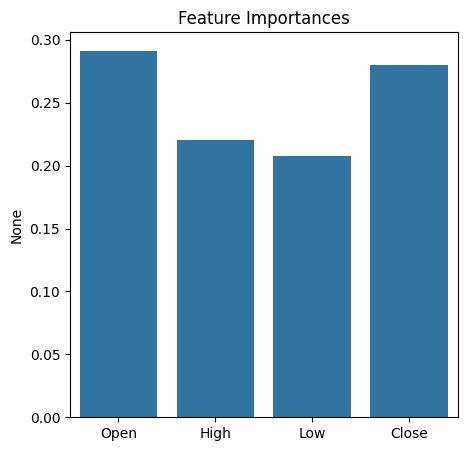

In [ ]:
# 특징 중요도 확인
print(basic_rf_clf.feature_importances_)
feature_importances_values = basic_rf_clf.feature_importances_
feature_importances = pd.Series(feature_importances_values)
plt.figure(figsize=(5,5)) # figure size 설정
plt.title('Feature Importances') # figure title 설정
sns.barplot(x=['Open','High','Low','Close'], y=feature_importances)
plt.show()

## Close 또는 Open이 있어야 Head,Body,Tail을 구할수 있으므로
## 중요도가 제일 높게 측정되는걸로 보임.


### 2.4 파라미터를 사용하여 학습하기

DecisionTree Best Parameter :  {'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 2}
RandomForest Best Parameter :  {'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
k-nn acuuracys :  [0.7194642857142857, 0.655892857142857, 0.6108928571428571, 0.5776785714285714, 0.5503571428571428, 0.531607142857143, 0.5153571428571427, 0.49678571428571433, 0.48678571428571427, 0.4735714285714286, 0.45839285714285716, 0.44910714285714287, 0.4442857142857143, 0.4376785714285714, 0.4303571428571429, 0.42339285714285707, 0.4149999999999999, 0.4126785714285714, 0.40107142857142863, 0.3944642857142857, 0.3883928571428571, 0.38303571428571426, 0.37875000000000003, 0.37339285714285714]


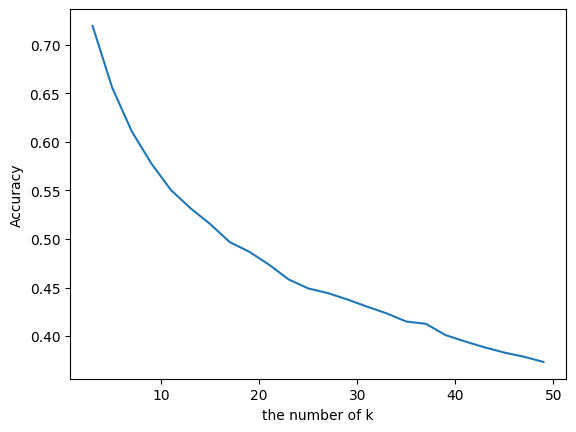

K-NN Best K :  3


In [ ]:
def SearchBestK(_cv, end, train, test): # 최적의 k 값을 찾는 함수
    end = 4 if end <= 3 else end+1
    max = 0
    k_index = -1
    list_socre = []
    for k in range(3, end, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        socres = cross_val_score(knn, train, test, cv=_cv, scoring="accuracy")
        socre = socres.mean()
        list_socre.append(socre)
        if socre > max:
            max = socre
            k_index = k
    print("k-nn acuuracys : ", list_socre)
    plt.plot(range(3, end, 2), list_socre)
    plt.xlabel('the number of k') # x축 제목 설정
    plt.ylabel('Accuracy') # y축 제목 설정
    plt.show() # 그래프 출
    return k_index

rf_param_grid = {
    "n_estimators" : [100, 200],
    "min_samples_leaf" : [2,3],
    "min_samples_split" : [2,3]
}

dt_param_grid={
    "max_depth" : [10, 50, 100],
    "min_samples_leaf" : [2,3],
    "min_samples_split" : [2,3],
    "criterion" : ["gini", "entropy"]
}

rf = RandomForestClassifier(random_state=0)
d_tree = tree.DecisionTreeClassifier(random_state=0)

rf_grid = GridSearchCV(basic_rf_clf, param_grid=rf_param_grid, scoring="accuracy", n_jobs=1)
df_grid = GridSearchCV(d_tree, param_grid=dt_param_grid, scoring="accuracy", n_jobs=1)

df_grid.fit(basic_x_train, basic_y_train)
rf_grid.fit(basic_x_train, basic_y_train.values.ravel())

print("DecisionTree Best Parameter : ", df_grid.best_params_)
print("RandomForest Best Parameter : ", rf_grid.best_params_)
print("K-NN Best K : ", SearchBestK(10, 50, basic_x_train, basic_y_train.values.ravel()))


In [ ]:
#K-NN
knn = KNeighborsClassifier(n_neighbors=3).fit(basic_x_train, basic_y_train.values.ravel()) # the best number of k is 3
knn_predicted = knn.predict(basic_x_test)

#decistion Tree
d_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=100,min_samples_leaf=2, min_samples_split=2, random_state=0)
d_tree = d_tree.fit(basic_x_train, basic_y_train.values.ravel())
tree_predicted = d_tree.predict(basic_x_test)

#random forest
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, min_samples_split=2, random_state=0)
rf = rf.fit(basic_x_train, basic_y_train.values.ravel())
rf_predicted = rf.predict(basic_x_test)

print("[accuarcy]")
print('random forest : {0:.4f}'.format(accuracy_score(basic_y_test, rf_predicted)))
print("k-nn : ", accuracy_score(basic_y_test, knn_predicted))
print("decistion tree : ", accuracy_score(basic_y_test, tree_predicted))

[accuarcy]
random forest : 0.6993
k-nn :  0.7264285714285714
decistion tree :  0.6307142857142857


### 2.5 PCA 차원 축소

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

[[ 0.48528506  0.48407178  0.47503853  0.49168311]
 [ 0.25883018  0.26097876  0.25651991  0.25884117]
 [-2.13967782 -2.14523875 -2.14080489 -2.13974971]
 ...
 [-0.27541196 -0.27922504 -0.27940899 -0.27222981]
 [ 0.3321888   0.32471962  0.32670107  0.33220233]
 [ 0.62402854  0.61633406  0.61540086  0.62405215]]


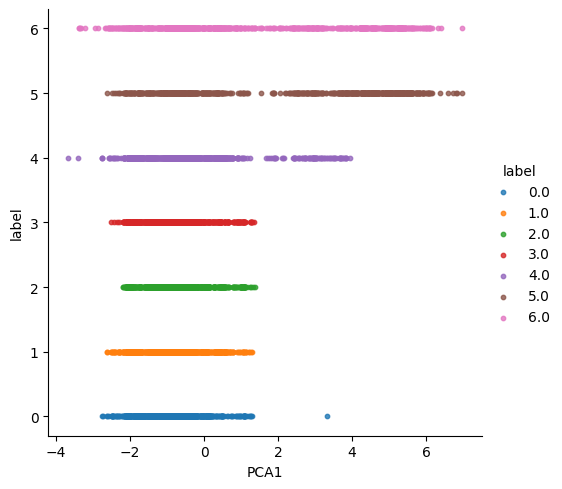

In [ ]:
pca_x_df = basic_df[["Open", "High", "Low", "Close"]]
pca_x_std = StandardScaler().fit_transform(pca_x_df)
print(pca_x_std)
pca_y_df = basic_df[["Label"]]

pca = decomposition.PCA(n_components=1)
sklearn_pca_x = pca.fit_transform(pca_x_std)

pca_result = pd.DataFrame(sklearn_pca_x, columns=['PCA1'])
pca_result["PCA2"] = 0.0
pca_result['label'] = pca_y_df

sns.lmplot(x='PCA1', y='label', data=pca_result, fit_reg=False,  # x-axis, y-axis, data, no line
           scatter_kws={"s": 10}, # marker size
           hue="label") # colo


# 시각화를 해서 보면,
# shadow(0,1), marubozu(2,3)의 라벨들의 x 데이터가 -3 ~ 2로 겹치므로
# 차원축소한 데이터로 학습시키기에는 부적절해 보인다.
# 또한 shadow(0,1)의 precision의 값이 낮은걸로 보아서
# upper shadow(0) 과 lower shadow(1)을 혼동하는 비율이 많은걸로 보임.

## 3) 보팅 앙상블

### 3.1 패키지 빌드

In [ ]:
from sklearn import datasets
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
import numpy as np
import matplotlib.pyplot as pl

### 3.2 하드 보팅

In [ ]:
voting_mode = VotingClassifier(estimators=[("Decision_Tree", d_tree), ("Random_Forest", rf),("k-NN", knn)], weights=[1,1,2], voting="hard")
voting_mode.fit(basic_x_train, basic_y_train.values.ravel())
hard_voting_predicted = voting_mode.predict(basic_x_test)
accuracy_score(basic_y_test, hard_voting_predicted)

0.7192857142857143

### 3.3 소프트 보팅

In [ ]:
voting_mode = VotingClassifier(estimators=[("Decision_Tree", d_tree), ("Random_Forest", rf),("k-NN", knn)], weights=[1,1,2], voting="soft")
voting_mode.fit(basic_x_train, basic_y_train.values.ravel())
soft_voting_predicted = voting_mode.predict(basic_x_test)
accuracy_score(basic_y_test, soft_voting_predicted)

0.7328571428571429

### 3.4 정확도 비교 시각화

([<matplotlib.axis.XTick at 0x7b1b2b238820>,
 [Text(0, 0, 'desition_tree'),
  Text(1, 0, 'knn'),
  Text(2, 0, 'random_forest'),
  Text(3, 0, 'hard voting'),
  Text(4, 0, 'soft voting')])

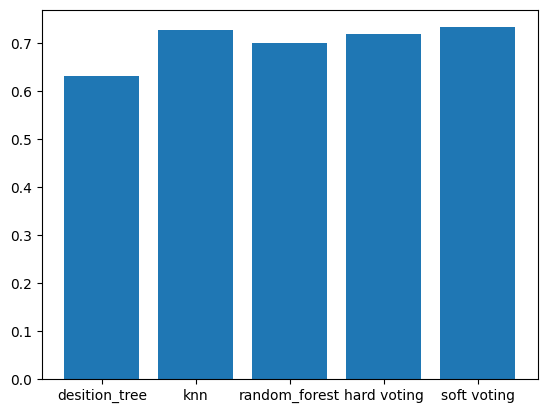

In [ ]:
x = np.arange(5)
plt.bar(x, height=[accuracy_score(basic_y_test, tree_predicted),
                   accuracy_score(basic_y_test, knn_predicted),
                   accuracy_score(basic_y_test, rf_predicted),
                   accuracy_score(basic_y_test, hard_voting_predicted),
                   accuracy_score(basic_y_test, soft_voting_predicted)])
plt.xticks(x, ['desition_tree', 'knn', 'random_forest', 'hard voting', 'soft voting'])

### 3.5 결과


In [ ]:
print('1. 하이퍼 파라미터가 없이 학습한 머신러닝 정확도')
print()
print('[Open, High, Low, Close]')
print('의사결정트리 예측 정확도: {0:.4f}'.format(basic_accuracy_dt))
print('랜덤 포레스트 예측 정확도: {0:.4f}'.format(basic_accuracy_rf))
print('K-NN 예측 정확도: {0:.4f}'.format(basic_accuracy_knn))

print()
print('[Head, Body, Tail]')
print()
print('의사결정트리 예측 정확도: {0:.4f}'.format(proce_accuracy_dt))
print('랜덤 포레스트 예측 정확도: {0:.4f}'.format(proce_accuracy_rf))
print('K-NN 예측 정확도: {0:.4f}'.format(proce_accuracy_knn))
print()

print("2. 하이퍼 파라미터를 설정하고 학습한 머신러닝 정확도")
print()
print('[Open, High, Low, Close]')
print("의사결정트리 예측 정확도 : {0:.4f}".format(accuracy_score(basic_y_test, tree_predicted)))
print('랜덤 포레스트 예측 정확도 : {0:.4f}'.format(accuracy_score(basic_y_test, rf_predicted)))
print("K-NN 예측 정확도 : {0:.4f}".format(accuracy_score(basic_y_test, knn_predicted)))
print("하드 보팅 예측 정확도 : {0:.4f}".format(accuracy_score(basic_y_test, hard_voting_predicted)))
print("소프트 보팅 예측 정확도 : {0:.4f}".format(accuracy_score(basic_y_test, soft_voting_predicted)))

1. 하이퍼 파라미터가 없이 학습한 머신러닝 정확도

[Open, High, Low, Close]
의사결정트리 예측 정확도: 0.6550
랜덤 포레스트 예측 정확도: 0.7314
K-NN 예측 정확도: 0.6671

[Head, Body, Tail]

의사결정트리 예측 정확도: 1.0000
랜덤 포레스트 예측 정확도: 1.0000
K-NN 예측 정확도: 0.9979

2. 하이퍼 파라미터를 설정하고 학습한 머신러닝 정확도

[Open, High, Low, Close]
의사결정트리 예측 정확도 : 0.6307
랜덤 포레스트 예측 정확도 : 0.6993
K-NN 예측 정확도 : 0.7264
하드 보팅 예측 정확도 : 0.7193
소프트 보팅 예측 정확도 : 0.7329
